In [1]:
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from dynax import (
    boxed_field,
    DynamicalSystem,
    fit_least_squares,
    Flow,
    non_negative_field,
    pretty,
    static_field,
)

np.random.seed(42)

Setting jax_enable_x64 to True.


# Example: parameter fitting of an ODE

In this example, we estimate the values and covariances of the parameters $m$, $r$, $r_2$ and $k$ of a forced, nonlinear mass-spring-damper system
$$
m ẍ +  r ẋ + r_2 ẋ |ẋ| + k x = u.
$$
We assume the measurement of the position $x$ in millineter, so the measurement equation is
$y = 1000x$.
Further, we have some prior knowledge of the system in terms of value bounds for the unknown parameters:
$$
\begin{align}
m &\in \mathbb R \\
r &\in [0, \infty) \\
r_2 &\in [0.01, 1] \\
k &\in [0.001, 2]
\end{align}
$$


In Dynax, the `DynamicalSystem` class models ODE with measurement equations. Bounds for trainable parameters arespecified with `boxed_field` or `non_negative_field`. Fixed parameters can be marked with `static_field`. 

In [2]:
class NonlinearDrag(DynamicalSystem):
    # Set the number of states (order of system) and inputs.
    n_states = 2
    n_inputs = 1
    
    # Declare parameters as dataclass fields.
    m: float
    r: float = non_negative_field()
    r2: float = boxed_field(lower=0.01, upper=1)
    k: float = boxed_field(lower=1e-3, upper=2)

    # Define the vector field of the dynamical system
    def vector_field(self, x, u, t):
        x1, x2 = x
        return jnp.array(
            [
                x2,
                (-self.r * x2 - self.r2 * jnp.abs(x2) * x2 - self.k * x1 + u)
                / self.m,
            ]
        )

    def output(self, x, u, t):
        return 1000*x[0]

We combine an instance of the dynamical system with an ODE solver via the `Flow` class. Flows represent forward models that solve an ODE.

In [10]:
true_model = Flow(
    system=NonlinearDrag(m=1.0, r=2.0, r2=0.15, k=1.0),
    solver=diffrax.Dopri8(),
    step=diffrax.PIDController(rtol=1e-3, atol=1e-6),
)
print("true forward model:", true_model)

true forward model: Flow(
  system=NonlinearDrag(
    n_states(static)=2,
    n_inputs(static)=1,
    m=1.0,
    r(boxed: (0.0, inf))=2.0,
    r2(boxed: (0.01, 1))=0.15,
    k(boxed: (0.001, 2))=1.0
  ),
  solver(static)=Dopri8(scan_kind=None),
  step(static)=PIDController(
    rtol=0.001,
    atol=1e-06,
    pcoeff=0,
    icoeff=1,
    dcoeff=0,
    dtmin=None,
    dtmax=None,
    force_dtmin=True,
    step_ts=None,
    jump_ts=None,
    factormin=0.2,
    factormax=10.0,
    norm=<function rms_norm>,
    safety=0.9,
    error_order=None
  ),
  dt0(static)=None
)


Let's create some data with the forward model.

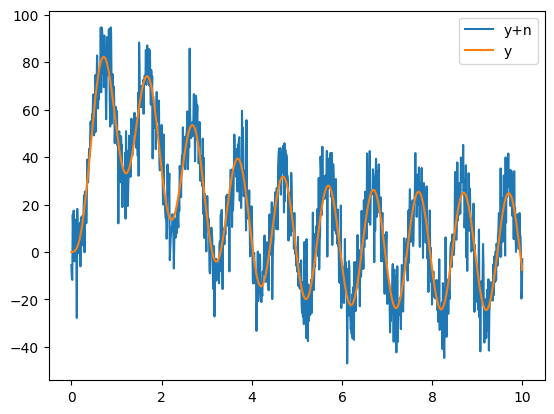

In [27]:
# time
t = np.linspace(0, 10, 1000)
# forcing signal
u = np.sin(t*2*np.pi)
# zero initial state
x0 = [0.0, 0.0]
# x are the states and y is the output
x, y = true_model(x0, t, u)
# add noise to measurement
yn = y + np.random.normal(size=y.shape, scale=10)

plt.plot(t, yn, label="y+n")
plt.plot(t, y, label="y")
plt.legend();

Let's create a new dynamical system object with some initial parameters that we want to fit.

In [28]:
init_model = Flow(
    system=NonlinearDrag(m=2.0, r=1.0, r2=1., k=2.0),
    solver=diffrax.Tsit5(),
    step=diffrax.PIDController(rtol=1e-3, atol=1e-6),
)
print("initial system:", init_model)

initial system: Flow(
  system=NonlinearDrag(
    n_states(static)=2,
    n_inputs(static)=1,
    m=2.0,
    r(boxed: (0.0, inf))=1.0,
    r2(boxed: (0.01, 1))=1.0,
    k(boxed: (0.001, 2))=2.0
  ),
  solver(static)=Tsit5(scan_kind=None),
  step(static)=PIDController(
    rtol=0.001,
    atol=1e-06,
    pcoeff=0,
    icoeff=1,
    dcoeff=0,
    dtmin=None,
    dtmax=None,
    force_dtmin=True,
    step_ts=None,
    jump_ts=None,
    factormin=0.2,
    factormax=10.0,
    norm=<function rms_norm>,
    safety=0.9,
    error_order=None
  ),
  dt0(static)=None
)


Combine the initial ODE system with an ODE solver and fit it using nonlinear Least-Squares.

In [29]:
res = fit_least_squares(model=init_model, t=t, y=yn, x0=x0, u=u, verbose=2)
pred_model = res.result
print("fitted system:", pretty(pred_model.system))
print("Normalized mean squared error:", res.nrmse)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.1826e-01                                    4.19e-01    
       1              2         1.3715e-01      3.81e-01       1.01e+00       1.11e-01    
       2              3         1.2552e-01      1.16e-02       1.15e-01       8.01e-03    
       3             10         1.2550e-01      2.50e-05       2.57e-05       1.15e-02    
       4             13         1.2548e-01      1.87e-05       1.32e-06       8.07e-03    
       5             18         1.2548e-01      0.00e+00       0.00e+00       8.07e-03    
`xtol` termination condition is satisfied.
Function evaluations 18, initial cost 5.1826e-01, final cost 1.2548e-01, first-order optimality 8.07e-03.
fitted system: NonlinearDrag(
  n_states(static)=2,
  n_inputs(static)=1,
  m=Array(0.96404107, dtype=float64),
  r(boxed: (0.0, inf))=Array(1.86260874, dtype=float64),
  r2(boxed: (0.01, 1))=Array(0.99998108, dtyp

Compare true and estimated output.

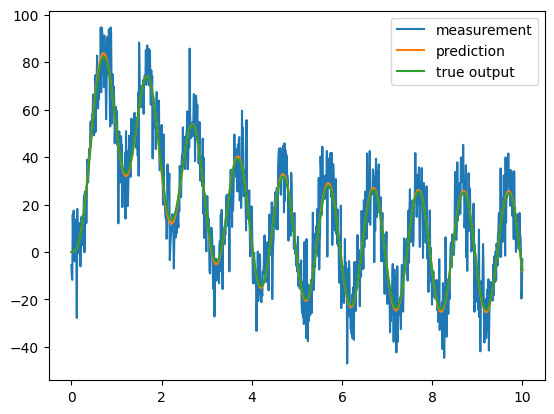

In [30]:
x_pred, _ = pred_model(x0, t, u)

plt.plot(t, yn, label="measurement")
plt.plot(t, res.y_pred, label="prediction")
plt.plot(t, y, label="true output")

plt.legend()
plt.show()

`fit_least_squares` also estimates the covariance matrix of the parameter estimates.

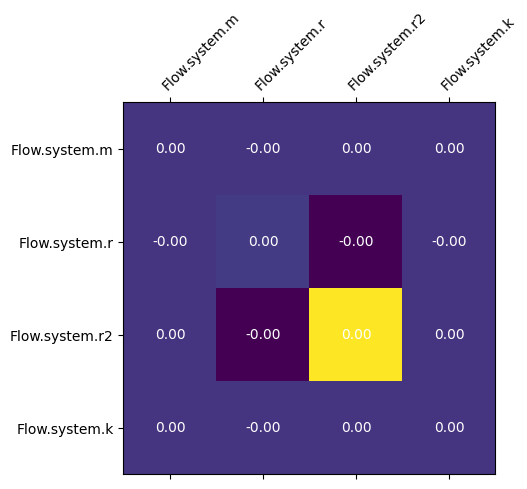

In [31]:
def plot_covariance(res):
    nparams = len(res.key_paths)

    plt.matshow(res.pcov)
    ax = plt.gca()
    ax.set_xticks(np.arange(nparams), labels=res.key_paths)
    ax.set_yticks(np.arange(nparams), labels=res.key_paths)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

    for i in range(nparams):
        for j in range(nparams):
            ax.text(j, i, f"{res.pcov[i, j]:.2f}", ha="center", va="center", color="w")


plot_covariance(res)

The parameter standard deviations are:

In [32]:
for kp, var in zip(res.key_paths, np.diag(res.pcov)):
    print(f"{kp}: {np.sqrt(var):.3f}")

Flow.system.m: 0.000
Flow.system.r: 0.012
Flow.system.r2: 0.069
Flow.system.k: 0.000
